<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a href="https://agrum.gitlab.io/pages/pyagrum.html" target="blank"><img src="https://agrum.gitlab.io/images/pyAgrum.png" align="right" style="height:75px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a><br/>
Author: <b>Aymen Merrouche</b> and Pierre-Henri Wuillemin.

<font size="+3" color="GREEN">**Counterfactual in a nutshell**</font>

In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

#### The 3 next cells describe the fastest way to build counterfactuals in pyAgrum

- build the model
- fill the CPTs
- compute counterfactuals

In [2]:
# building the model
edex = gum.fastBN("Ux[-2,10]->experience[0,20]<-education{low|medium|high}->salary[65,150]<-Us[0,25];experience->salary")
edex

(pyAgrum.BayesNet<double>@0x564a5a3a6fb0) BN{nodes: 5, arcs: 5, domainSize: 10^6.26276, dim: 140049, mem: 1Mo 83Ko 264o}

In [3]:
# Filling the CPTs

# priors
edex.cpt("Us").fillWith(1).normalize()
edex.cpt("Ux").fillWith(1).normalize()
edex.cpt("education")[:] = [0.4, 0.4, 0.2]

# two equations
edex.cpt("experience").fillWithFunction("10-4*education+Ux")
edex.cpt("salary").fillWithFunction("round(65+2.5*experience+5*education+Us)");

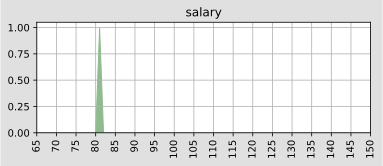

In [4]:
# Counterfactual
pot=csl.counterfactual(cm = csl.CausalModel(edex), 
                       profile = {'experience':'8', 'education': 'low', 'salary' : '86'},
                       whatif={"education"},
                       on={"salary"}, 
                       values = {"education" : 'medium'})
gnb.showProba(pot)

# CounterfactualS as a function

### We can now fill (most of) the holes in :

<table>
    <tr>
        <th>Employé</th> <th>EX(u)</th> <th>ED(u)</th> <th> $S_{0}(u)$</th> <th> $S_{1}(u)$</th> <th>$S_{2}(u)$</th>
    </tr>
    <tr>
        <td>Alice</td> <td>8</td> <td>0</td> <td>86,000</td> <td>?</td> <td>?</td> 
    </tr>
    <tr>
        <td>Bert</td> <td>9</td> <td>1</td> <td>?</td> <td>92,500</td> <td>?</td> 
    </tr>
    <tr>
        <td>Caroline</td> <td>9</td> <td>2</td> <td>?</td> <td>?</td> <td>97,000</td> 
    </tr>
    <tr>
        <td>David</td> <td>8</td> <td>1</td> <td>?</td> <td>91,000</td> <td>?</td>
    </tr>
    <tr>
        <td>Ernest</td> <td>12</td> <td>1</td> <td>?</td> <td>100,000</td> <td>?</td> 
    </tr>
    <tr>
        <td>Frances</td> <td>13</td> <td>0</td> <td>97,000</td> <td>?</td> <td>?</td> 
    </tr>
    <tr>
        <td>etc</td> <td> </td> <td> </td> <td> </td> <td> </td> <td> </td> 
    </tr>
</table>

In [5]:
def mean(p):
    return sum([p.variable(0).numerical(i)*p[i] for i in range(p.variable(0).domainSize())])
def affCounterfactualForStudent(model,name,ex,ed,sa,value):
    try:
        s0=csl.counterfactual(cm = model,
                              profile = {'experience':str(ex), 'education': ed, 'salary' : str(sa)},
                              whatif={"education"},
                              on={"salary"},
                              values = {"education" : value})    
        print("{:5.1f}| ".format(mean(s0)),end="")
    except:
        print(" --  | ",end="")        
def forStudent(model,name,ex,ed,sa):
    print("| {:20}| {:2.0f}| {:7}|  {:5.1f}|| ".format(name,ex,ed,sa),end="")
    for value in ['low','medium','high']:
        affCounterfactualForStudent(model,name,ex,ed,sa,value)    
    print()

print("| Name                | Ex| Ed     | S     || s0   | s1   | s2   |")
print("------------------------------------------------------------------")
d=csl.CausalModel(edex)
forStudent(d,"Alice",8,"low",86)
forStudent(d,"Bert",9,"medium",92)
forStudent(d,"Caroline",9,"high",97)
forStudent(d,"Caroline",9,"high",98)
forStudent(d,"David",8,"medium",91)
forStudent(d,"Ernest",12,"medium",100)
forStudent(d,"Frances",13,"low",97)
forStudent(d,"Frances",13,"low",98)

| Name                | Ex| Ed     | S     || s0   | s1   | s2   |
------------------------------------------------------------------
| Alice               |  8| low    |   86.0||  86.0|  81.0|  76.0| 
| Bert                |  9| medium |   92.0||  98.0|  92.0|  88.0| 
| Caroline            |  9| high   |   97.0||  --  |  --  |  --  | 
| Caroline            |  9| high   |   98.0|| 108.0| 103.0|  98.0| 
| David               |  8| medium |   91.0||  96.0|  91.0|  86.0| 
| Ernest              | 12| medium |  100.0|| 105.0| 100.0|  95.0| 
| Frances             | 13| low    |   97.0||  --  |  --  |  --  | 
| Frances             | 13| low    |   98.0||  98.0|  93.0|  88.0| 


We cannot answer neither for Caroline or Frances when salary=97 because their profiles are impossible *in our modelisation*...

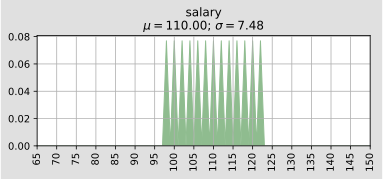

In [6]:
gnb.showPosterior(edex,target="salary",evs={'experience':"9", 'education': "high"}) # 97 is not possible for Caroline

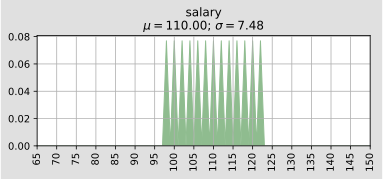

In [7]:
gnb.showPosterior(edex,target="salary",evs={'experience':"13", 'education': "low"}) # 97 is not possible for Frances